<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Kolchenko (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center>Assignment #6
### <center> Beating baselines in "How good is your Medium article?"
    
<img src='../../img/medium_claps.jpg' width=40% />


[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "A6 baseline" (~1.45 Public LB score). Do not forget about our shared ["primitive" baseline](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline) - you'll find something valuable there.

**Your task:**
 1. "Freeride". Come up with good features to beat the baseline "A6 baseline" (for now, public LB is only considered)
 2. You need to name your [team](https://www.kaggle.com/c/how-good-is-your-medium-article/team) (out of 1 person) in full accordance with the [course rating](https://drive.google.com/open?id=19AGEhUQUol6_kNLKSzBsjcGUU3qWy3BNUg8x8IFkO3Q). You can think of it as a part of the assignment. 16 credits for beating the mentioned baseline and correct team naming.

In [1]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from bs4 import BeautifulSoup

The following code will help to throw away all HTML tags from an article content.

In [78]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [79]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [131]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author', 'tags']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    content_list = []
    published_list = []
    author_list = []
    title_list = []
    tags_list = []
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            content_list.append(content_no_html_tags)
            
            published = json_data['published']['$date']

            published_list.append(published)
            
            title = json_data['title'].split('\u2013')[0].strip() #'Medium Terms of Service – Medium Policy – Medium'
            title = title.replace('\n', ' ').replace('\r', ' ')
            title_list.append(title)
            
            author = json_data['meta_tags']['author'].strip()
            author_list.append(author)
            
            tags_str = []
            soup = BeautifulSoup(content, 'lxml')
            try:
                tag_block = soup.find('ul', class_='tags')
                tags = tag_block.find_all('a')
                for tag in tags:
                    tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
                tags = ' '.join(tags_str)
            except Exception:
                tags = ' '
                #tags = 'None'
            tags_list.append(tags)
            #print(tags)
    
    feature_files[0].write('\n'.join(content_list))
    feature_files[1].write('\n'.join(published_list))
    feature_files[2].write('\n'.join(title_list))
    feature_files[3].write('\n'.join(author_list))
    feature_files[4].write('\n'.join(tags_list))
    
    feature_files[0].close()
    feature_files[1].close()
    feature_files[2].close()
    feature_files[3].close()
    feature_files[4].close()
            

In [3]:
PATH_TO_DATA = 'Assgn6Data' # modify this if you need to

In [133]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [151]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [4]:
#Adding Time features: publication hour, whether it's morning, afternoon, evening, night, whether it's a weekend

train_time_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_published.txt'), header=None)
train_time_df.columns=['datetime']
train_time_df['datetime'] = pd.to_datetime(train_time_df['datetime'], format='%Y-%m-%dT%H:%M:%S.%fZ')
train_time_df['hour'] =  pd.DatetimeIndex(train_time_df['datetime']).hour
train_time_df['month'] =  pd.DatetimeIndex(train_time_df['datetime']).month

train_time_df['morning'] = train_time_df['hour'].apply(lambda x: 1 if (x>=6) & (x<12) else 0)
train_time_df['afternoon'] = train_time_df['hour'].apply(lambda x: 1 if (x>=12) & (x<17) else 0)
train_time_df['evening'] = train_time_df['hour'].apply(lambda x: 1 if (x>=17) & (x<22) else 0)
train_time_df['night'] = train_time_df['hour'].apply(lambda x: 1 if (x>=22) | (x<6) else 0)
train_time_df['weekend'] = ((pd.DatetimeIndex(train_time_df['datetime']).dayofweek) // 5 == 1).astype(int)
train_time_df = train_time_df.drop(columns=['hour'])
train_time_df = train_time_df.drop(columns = ['datetime']) #dropped since csr_matrix could not process the datetime object

In [5]:
train_time_df.head()

,month,morning,afternoon,evening,night,weekend
0,8,0,0,0,1,0
1,8,1,0,0,0,0
2,2,0,1,0,0,1
3,5,1,0,0,0,1
4,6,0,1,0,0,1


In [6]:
X_train_time_features_sparse = csr_matrix(train_time_df)

In [7]:
X_train_time_features_sparse

<62313x6 sparse matrix of type '<class 'numpy.int64'>'
	with 135047 stored elements in Compressed Sparse Row format>

In [8]:
train_tags_df = pd.read_table(os.path.join(PATH_TO_DATA, 'train_tags.txt'), header=None, skip_blank_lines=False)
train_tags_df = train_tags_df.replace(np.NaN,'',regex=True)
train_tags_df.head()

,0
0,TermsAndConditions Terms Medium
1,
2,田野 歷史 閩東 大刀會 走私
3,Photography Cameras Tech MIT Science
4,Gaming Games AndroidGames GooglePlayStore Alone


In [9]:
train_tags_df = pd.read_table(os.path.join(PATH_TO_DATA, 'train_tags.txt'), header=None, skip_blank_lines=False)
train_tags_df = train_tags_df.replace(np.NaN,'',regex=True)

tagenc = LabelEncoder()
df = train_tags_df.apply(tagenc.fit_transform)
print(df.head())
tag_ohe = OneHotEncoder(handle_unknown='ignore')
X_train_tags_sparse = tag_ohe.fit_transform(df)
X_train_tags_sparse.shape

       0
0  47054
1      0
2  53456
3  33273
4  18512


(62313, 53477)

In [10]:
#Bag of authors (i.e. One-Hot-Encoded author names)
train_author_df = pd.read_table(os.path.join(PATH_TO_DATA, 'train_author.txt'), header=None, sep='\n')
train_author_df.head()

,0
0,Medium
1,Medium
2,Yun-Chen Chien（簡韻真）
3,Vaibhav Khulbe
4,Vaibhav Khulbe


In [11]:
train_author_df.shape

(62313, 1)

In [12]:
labelenc = LabelEncoder()
df = train_author_df.apply(labelenc.fit_transform)
#print(df.head())
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_author_sparse = encoder.fit_transform(df)
X_train_author_sparse.shape

(62313, 31331)

In [140]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
wnl = WordNetLemmatizer()
fo = open(os.path.join(PATH_TO_DATA, 'train_content.txt'), 'r', encoding='utf-8')
fw = open(os.path.join(PATH_TO_DATA, 'train_content_lem.txt'), 'w', encoding='utf-8')

while fo.readline() != '':
    line = fo.readline()
    for w in nltk.word_tokenize(line):
        #print(w)
        str = wnl.lemmatize(w)
        fw.write(str)
        fw.write(' ')
    fw.write('\n')
    
fw.close()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
contentvectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000, stop_words='english')
X_train_content_sparse = contentvectorizer.fit_transform(open(os.path.join(PATH_TO_DATA, 'train_content.txt'), 'r', encoding='utf-8'))

In [142]:
X_train_content_sparse

<31157x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 17200472 stored elements in Compressed Sparse Row format>

In [137]:
#Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000, stop_words='english')
X_train_title_sparse = vectorizer.fit_transform(open(os.path.join(PATH_TO_DATA, 'train_title.txt'), 'r', encoding='utf-8'))

In [138]:
X_train_title_sparse.shape

(62313, 100000)

In [56]:
#Repeat the same transformations for test set also

#Adding Time features: publication hour, whether it's morning, afternoon, evening, night, whether it's a weekend

test_time_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_published.txt'), header=None)
test_time_df.columns=['datetime']
test_time_df['datetime'] = pd.to_datetime(test_time_df['datetime'], format='%Y-%m-%dT%H:%M:%S.%fZ')
test_time_df['hour'] =  pd.DatetimeIndex(test_time_df['datetime']).hour
test_time_df['month'] =  pd.DatetimeIndex(test_time_df['datetime']).month

test_time_df['morning'] = test_time_df['hour'].apply(lambda x: 1 if (x>=6) & (x<12) else 0)
test_time_df['afternoon'] = test_time_df['hour'].apply(lambda x: 1 if (x>=12) & (x<17) else 0)
test_time_df['evening'] = test_time_df['hour'].apply(lambda x: 1 if (x>=17) & (x<22) else 0)
test_time_df['night'] = test_time_df['hour'].apply(lambda x: 1 if (x>=22) | (x<6) else 0)
test_time_df['weekend'] = ((pd.DatetimeIndex(test_time_df['datetime']).dayofweek) // 5 == 1).astype(int)
test_time_df = test_time_df.drop(columns=['hour'])
test_time_df = test_time_df.drop(columns = ['datetime']) #dropped since csr_matrix could not process the datetime object

X_test_time_features_sparse = csr_matrix(test_time_df)

#Bag of authors (i.e. One-Hot-Encoded author names)
# *********** use the same as train set of encoders so that the dimension remains the same ***********
test_author_df = pd.read_table(os.path.join(PATH_TO_DATA, 'test_author.txt'), header=None, sep='\n')
df = test_author_df.apply(labelenc.fit_transform)
X_test_author_sparse = encoder.transform(df)

#Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
contentvectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000, stop_words='english')
X_test_content_sparse = contentvectorizer.fit_transform(open(os.path.join(PATH_TO_DATA, 'test_content.txt'), 'r', encoding='utf-8'))

#Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000, stop_words='english')
X_test_title_sparse = vectorizer.fit_transform(open(os.path.join(PATH_TO_DATA, 'test_title.txt'), 'r', encoding='utf-8'))

In [57]:
test_tags_df = pd.read_table(os.path.join(PATH_TO_DATA, 'test_tags.txt'), header=None, skip_blank_lines=False)

test_tags_df = test_tags_df.replace(np.NaN,'',regex=True)
df = test_tags_df.apply(tagenc.fit_transform)

X_test_tags_sparse = tag_ohe.transform(df)
print(X_test_tags_sparse.shape)

(34645, 53477)


**Join all sparse matrices.**

In [135]:
X_train_sparse = hstack([X_train_content_sparse, X_train_title_sparse,
                         X_train_author_sparse, X_train_tags_sparse,
                         X_train_time_features_sparse]).tocsr()

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 31157, expected 62313.

In [68]:
X_train_sparse

<62313x284814 sparse matrix of type '<class 'numpy.float64'>'
	with 34786594 stored elements in Compressed Sparse Row format>

In [60]:
X_test_sparse = hstack([X_test_content_sparse, X_test_title_sparse,
                        X_test_author_sparse, X_test_tags_sparse,
                        X_test_time_features_sparse]).tocsr()

In [69]:
X_test_sparse

<34645x284814 sparse matrix of type '<class 'numpy.float64'>'
	with 18489559 stored elements in Compressed Sparse Row format>

**Read train target and split data for validation.**

In [62]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [63]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [64]:
y_valid.shape

(18694,)

**Train a simple Ridge model and check MAE on the validation set.**

In [77]:
#from sklearn.linear_model import RidgeCV
#ridge = RidgeCV()
ridge = Ridge(alpha=8.0, max_iter=500, random_state=17, normalize=True)
ridge.fit(X_train_part_sparse, y_train_part)

Ridge(alpha=8.0, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, random_state=17, solver='auto', tol=0.001)

In [78]:
ridge_pred = ridge.predict(X_valid_sparse)
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(2.074080109614766, 6.957223318084234)

In [67]:
*******

SyntaxError: invalid syntax (<ipython-input-67-bfb6a25a3121>, line 1)

## Trying out other models

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
lr.fit(X_train_part_sparse, y_train_part)

In [ ]:
lr_pred = lr.predict(X_valid_sparse)
valid_mae = mean_absolute_error(y_valid, lr_pred)
valid_mae, np.expm1(valid_mae)

In [ ]:
lr_test_pred = lr.predict(X_test_sparse)
write_submission_file(lr_test_pred, os.path.join(PATH_TO_DATA,
                                                    'assignment6_medium_submission.csv'))

## Iteration details:

(1.09, 1.98) - baseline submission. Score = 2.53

(1.5051589468988862, 3.504869608439871) - with normalize=True added. Score = 2.42

(1.3789271765302742, 2.9706395463780333) - alpha=5, max_iter = 100. Score = 2.24784

(2.5367264801665335, 11.638231679604928) - all above + publication month added to train and test set. Score = 2.05299

(2.4821944178050788, 10.967497313542504) - with tags added to the mix. Score = 2.03023

(1.107657016496021, 2.027257264935505) - with Linear Regression. Score = 2.58

(1.186681460828143, 2.2761909794535646) - Linear Regression with normalize=True. Score = 2.06

(2.2657210922583997, 8.638072035069209) - back to Ridge with alpha=8, max_iter=500. Score = 2.00495

(2.074080109614766, 6.957223318084234) - Ridge with stop_words added to tfidf content and title. Score = 1.97409


(1.5, 2.8)

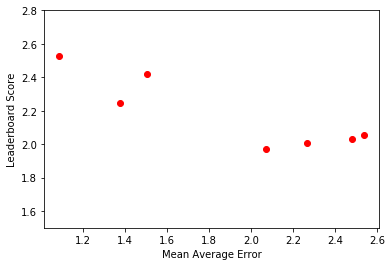

In [93]:
mae = [1.09, 1.5051589468988862, 1.3789271765302742, 2.5367264801665335, 2.4821944178050788, 2.2657210922583997, 2.074080109614766 ]
score = [2.53, 2.42, 2.24784, 2.05299, 2.03023, 2.00495, 1.97409]
from matplotlib import pyplot as plt
plt.plot(mae, score, 'ro')
plt.xlabel('Mean Average Error')
plt.ylabel('Leaderboard Score')
plt.ylim(1.5, 2.8)


**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [70]:
X_train_sparse.shape
y_train.shape

(62313,)

In [71]:
X_test_sparse.shape

(34645, 284814)

In [80]:
ridge.fit(X_train_sparse, y_train)
ridge_test_pred = ridge.predict(X_test_sparse)

In [ ]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [81]:
write_submission_file(ridge_test_pred, os.path.join(PATH_TO_DATA,
                                                    'assignment6_medium_submission.csv'))

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [ ]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      os.path.join(PATH_TO_DATA,
                                   'medium_all_zeros_submission.csv'))

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [ ]:
ridge_test_pred*2

In [ ]:
ridge_test_pred_modif = ridge_test_pred * 5

In [ ]:
write_submission_file(ridge_test_pred_modif, 
                      os.path.join(PATH_TO_DATA,
                                   'assignment6_medium_submission_with_hack.csv'))

That's it for the assignment. Much more credits will be given to the winners in this competition, check [course roadmap](https://mlcourse.ai/roadmap). Do not spoil the assignment and the competition - don't share high-performing kernels (with MAE < 1.5).

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!

<img src='../../img/kaggle_shakeup.png' width=50%>